In [1]:
import os, pickle, re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
from natsort import humansorted

import pandas as pd
import numpy as np

import scanpy as sc
from anndata import AnnData as ad

# Andreas' paper

In [2]:
GSE121861_obs = pd.read_excel("/Users/caibin/Downloads/Kumar_2018/Kumar_2018_column_information.xlsx", index_col=0).T
GSE121861_var = pd.read_excel("/Users/caibin/Downloads/Kumar_2018/Kumar_2018_row_information.xlsx", index_col=0)
GSE121861 = sc.read_csv("/Users/caibin/Downloads/Kumar_2018/Kumar_2018_data_matrix.csv").T

In [3]:
GSE121861.obs = GSE121861_obs
GSE121861.var = GSE121861_var

/Users/caibin/miniconda3/envs/general/lib/python3.11/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['Sox17', 'Mrpl15', 'Lypla1', 'Gm37988', 'Tcea1']

    Inferred to be: mixed

  value_idx = self._prep_dim_index(value.index, attr)


In [4]:
GSE121861.var_names = GSE121861.var_names.astype(str)

In [5]:
# GSE121861 = sc.read("GSE121861_normalized.h5ad")

In [6]:
GSE121861.obs["predicted_cell_type"] = GSE121861.obs["predicted_cell_type"].replace("M", "Macro.")
# GSE121861.obs["predicted_cell_type"] = GSE121861.obs["predicted_cell_type"].replace("EMT6", "Malignant")
# GSE121861.obs["predicted_cell_type"] = GSE121861.obs["predicted_cell_type"].replace("CT26", "Malignant")
# GSE121861.obs["predicted_cell_type"] = GSE121861.obs["predicted_cell_type"].replace("CT26", "Malignant")
# GSE121861.obs["predicted_cell_type"] = GSE121861.obs["predicted_cell_type"].replace("CT26", "Malignant")
# GSE121861.obs["predicted_cell_type"] = GSE121861.obs["predicted_cell_type"].replace("M", "Macrophage")
GSE121861 = GSE121861[GSE121861.obs["predicted_cell_type"]!="RBC"]

In [7]:
list(GSE121861.obs["predicted_cell_type"].unique())

['CT26',
 'Macro.',
 'CAF',
 'Tcell',
 'NK',
 'MC38',
 'pDC',
 'Bcell',
 'LL2',
 'B16F10',
 'EMT6']

In [8]:
GSE121861[GSE121861.obs["predicted_cell_type"]=="NK"][:, GSE121861.var_names.str.startswith("Klra")].to_df().sum(axis=0).sort_values(ascending=False).index

Index(['Klra9', 'Klra3', 'Klra7', 'Klra4', 'Klra8', 'Klra2', 'Klra5', 'Klra6',
       'Klra17', 'Klra1', 'Klra10'],
      dtype='object', name='Genes')

In [9]:
Klra_genes = GSE121861[GSE121861.obs["predicted_cell_type"]=="NK"][:, GSE121861.var_names.str.startswith("Klra")].to_df().sum(axis=0).sort_values(ascending=False).index

In [10]:
GSE121861 = GSE121861[GSE121861.obs["predicted_cell_type"].isin(["Tcell", "NK", "Macro.", "Bcell", "pDC", "CAF"])]

In [14]:
pwd

'/Users/caibin/Documents/github/IGSF8-manuscript/notebooks'

/Users/caibin/miniconda3/envs/general/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/caibin/miniconda3/envs/general/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/caibin/miniconda3/envs/general/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot

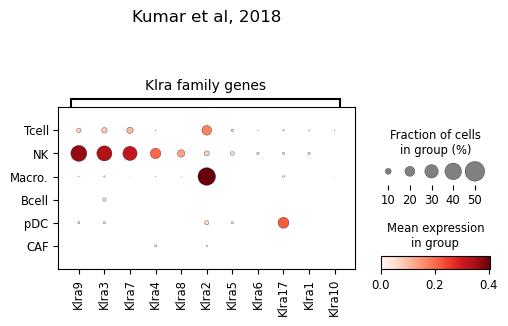

In [16]:
markers = {"Klra family genes": Klra_genes,
           # "Igsf8": "Igsf8"
          }
dp = sc.pl.dotplot(GSE121861,
                   markers, 
                   groupby='predicted_cell_type', 
                   categories_order=["Tcell", "NK", "Macro.", "Bcell", "pDC", "CAF"],
                   var_group_rotation=0,
                   title="Kumar et al, 2018",
                   dendrogram=None,
                   return_fig=False,
                   save="figures"
                  )
# dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

## BulkRNAseq of isolated immune cells from mouse PBMC

In [20]:
mouse = pd.read_csv("/Users/caibin/Downloads/E-MTAB-3079-query-results.tpms.tsv", sep='\t', skiprows=[0,1,2,3])
mouse = mouse.set_index("Gene Name").drop(columns=['Gene ID'])
Klra = mouse[mouse.index.str.startswith('Klra')]
Klra = Klra.loc[Klra.mean(axis=1).sort_values().index, Klra.mean().sort_values().index]

In [21]:
Klra

,fetal liver hematopoietic progenitor cell,Kit and Sca1-positive hematopoietic stem cell,granulocyte monocyte progenitor cell,megakaryocyte-erythroid progenitor cell,T cell,common myeloid progenitor,nucleate erythrocyte,common lymphoid progenitor,megakaryocyte,monocyte,lymphocyte of B lineage,granulocyte,natural killer cell,dendritic cell
Gene Name,,,,,,,,,,,,,,
Klra11-ps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,0.5,19.0
Klra6,NaN,0.3,0.3,NaN,NaN,0.4,0.3,1.0,2.0,0.4,5.0,NaN,75.0,54.0
Klra17,NaN,NaN,0.5,0.6,NaN,3.0,4.0,3.0,30.0,14.0,40.0,118.0,NaN,49.0
Klra2,0.3,1.0,3.0,2.0,0.2,6.0,6.0,6.0,63.0,128.0,4.0,232.0,1.0,140.0
Klra1,NaN,0.2,0.3,0.2,1.0,0.9,0.2,2.0,5.0,0.1,34.0,NaN,310.0,160.0
Klra10,NaN,0.4,NaN,0.8,NaN,NaN,NaN,NaN,1.0,NaN,4.0,NaN,115.0,182.0
Klra5,NaN,NaN,NaN,NaN,0.3,NaN,NaN,0.3,2.0,NaN,2.0,3.0,401.0,32.0
Klra3,NaN,0.2,NaN,0.3,1.0,0.3,NaN,0.7,5.0,NaN,15.0,NaN,317.0,425.0
Klra7,NaN,0.5,0.7,1.0,1.0,3.0,0.6,3.0,5.0,NaN,60.0,NaN,117.0,791.0


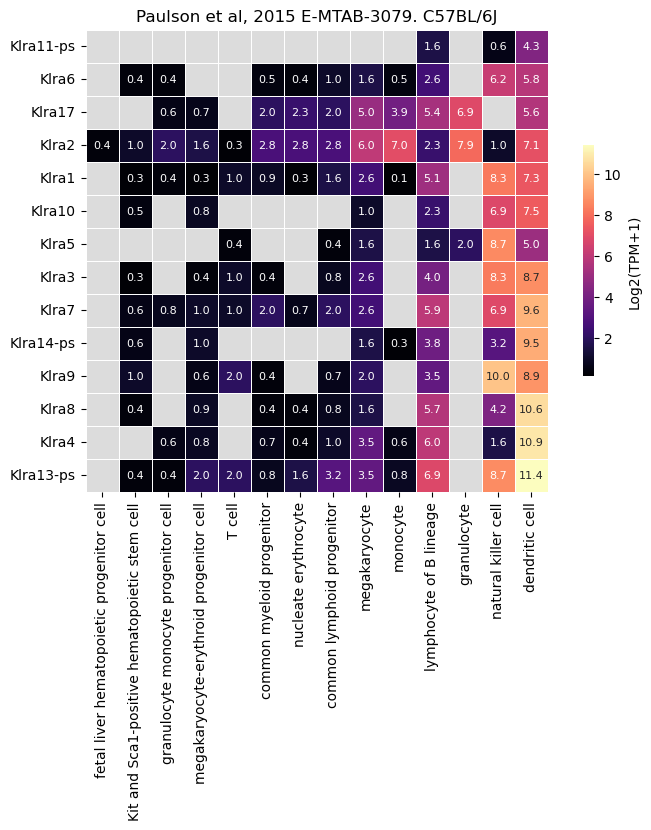

In [34]:
import matplotlib as mpl

plt.figure(figsize=(9,6))
cmap = mpl.colormaps.get_cmap('magma')
cmap.set_bad("gainsboro")

ax = sns.heatmap(np.log2(Klra+1), 
                 annot=True, 
                 annot_kws={'fontsize':8},fmt=".1f",
                 cbar_kws={'label': 'Log2(TPM+1)', 'shrink': .5},
                 linewidth=.5, 
                 cmap=cmap, 
                 square=True)
ax.set_ylabel("")
plt.title('Paulson et al, 2015 E-MTAB-3079. C57BL/6J')
plt.savefig("../figures/Reviewer1_point1_Klras_bulk.pdf",  bbox_inches = "tight")

# GSE127465

In [76]:
GSE127465_meta = pd.read_csv("/Users/caibin/Downloads/GSE127465_mouse_cell_metadata_15939x12.tsv.gz", index_col=None, sep="\t")
GSE127465_genes = pd.read_csv("/Users/caibin/Downloads/GSE127465_gene_names_mouse_28205.tsv.gz", index_col=0, header=None)
GSE127465_mtx = sc.read_mtx("/Users/caibin/Downloads/GSE127465_mouse_counts_normalized_15939x28205.mtx.gz")
GSE127465_mtx.var_names = GSE127465_genes.rename_axis("genes").index
GSE127465_mtx.var_names = GSE127465_mtx.var_names.astype(str)
GSE127465_mtx.obs = GSE127465_meta

In [97]:
tmp = GSE127465_mtx[GSE127465_mtx.obs["Major cell type"]=="NK cells"].to_df()
tmp = tmp.loc[:, tmp.columns.str.startswith("Klra")].copy()
Klra_genes = tmp.sum(axis=0).sort_values(ascending=False).index

/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


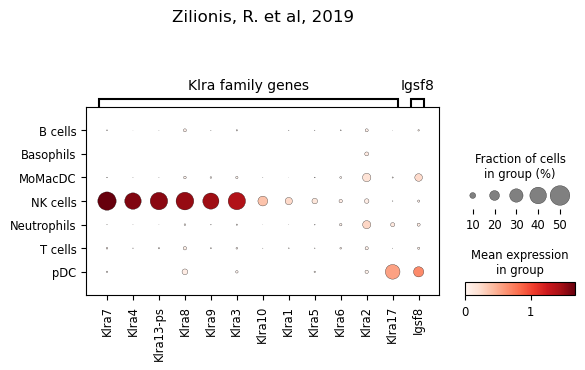

In [98]:
markers = {"Klra family genes": Klra_genes,
           "Igsf8": "Igsf8"
          }
dp = sc.pl.dotplot(GSE127465_mtx,
                   markers, 
                   'Major cell type', 
                   var_group_rotation=0,
                   title="Zilionis, R. et al, 2019",
                   dendrogram=None,
                   return_fig=False)
# dp.ax.text(10,4, 'test')
# dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

# GSE123534

In [ ]:
GSE123534 = sc.read_csv("/Users/caibin/Downloads/GSE123534_RAW/GSM3506244_WT_TU_NK.csv.gz", delimiter=";").T
GSE123534

In [86]:
sc.pl.violin(GSE123534, keys='S_score', groupby='bulk_labels', rotation=90)

""
Xkr4
Gm1992
Gm37381
Rp1
Rp1.1
...
AC168977.1
PISD
DHRSX
Vmn2r122


In [21]:
GSE121861.obs.query('predicted_cell_type=="NK"').groupby(['Model']).count()[['predicted_cell_type']].sort_values('predicted_cell_type', ascending=False)

/var/folders/tf/0py1zbcx6g5_r9bpq5dw4f6h0000gn/T/ipykernel_77736/118125736.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  GSE121861.obs.query('predicted_cell_type=="NK"').groupby(['Model']).count()[['predicted_cell_type']].sort_values('predicted_cell_type', ascending=False)


,predicted_cell_type
Model,
SA1N,11
MC38,10
CT26,8
B16F10,6
LL2,2
EMT6,0


In [2]:
adata = sc.read('/Users/caibin/Downloads/local.h5ad', backed='r')

In [16]:
!aws s3 cp /Users/caibin/Downloads/local.h5ad s3://gv20bioinformatics/Shared/scRNAseq_datasets/TabulaSapiens/TabulaSapiens.h5ad

upload: ../../../../Downloads/local.h5ad to s3://gv20bioinformatics/Shared/scRNAseq_datasets/TabulaSapiens/TabulaSapiens.h5ad


In [3]:
adata

AnnData object with n_obs × n_vars = 483152 × 58604 backed at '/Users/caibin/Downloads/local.h5ad'
    obs: 'tissue_in_publication', 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_predicti

In [5]:
adata_meta1 = pd.read_csv("/Users/caibin/Downloads/GSE201333_RAW/GSM6058681_TabulaSapiens_metadata.csv.gz")

In [6]:
adata_meta1

,cell_id,organ_tissue,method,donor,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,gender
0,AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,NaN,7633.0,2259,macrophage,Monocyte/Macrophage,True,immune,male
1,AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,NaN,2858.0,1152,monocyte,Monocyte,True,immune,male
2,AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,NaN,7787.0,2983,endothelial cell of hepatic sinusoid,Endothelial,True,endothelial,male
3,AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,NaN,10395.0,2598,macrophage,Monocyte/Macrophage,True,immune,male
4,AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,NaN,6610.0,2125,liver dendritic cell,Dendritic cell,True,immune,male
...,...,...,...,...,...,...,...,...,...,...,...,...
483147,TSP2_Vasculature_aorta_SS2_B114577_B133059_End...,Vasculature,smartseq2,TSP2,aorta,13205.0,579,endothelial cell,endothelial cell,True,endothelial,female
483148,TSP2_Vasculature_aorta_SS2_B114577_B133059_End...,Vasculature,smartseq2,TSP2,aorta,9565.0,529,endothelial cell,endothelial cell,True,endothelial,female
483149,TSP2_Vasculature_aorta_SS2_B114577_B133059_End...,Vasculature,smartseq2,TSP2,aorta,195639.0,2753,endothelial cell,endothelial cell,True,endothelial,female
483150,TSP2_Vasculature_aorta_SS2_B114577_B133059_End...,Vasculature,smartseq2,TSP2,aorta,37260.0,984,endothelial cell,endothelial cell,True,endothelial,female


In [7]:
adata1 = sc.read('/Users/caibin/Downloads/GSE201333_RAW/GSM6058681_TabulaSapiens.h5ad', backed='r')

In [15]:
adata1.X

<HDF5 sparse dataset: format 'csr', shape (483152, 58870), type '<f4'>

In [13]:
adata.raw

In [9]:
adata.obs.columns

Index(['tissue_in_publication', 'assay_ontology_term_id', 'donor_id',
       'anatomical_information', 'n_counts_UMIs', 'n_genes',
       'cell_ontology_class', 'free_annotation', 'manually_annotated',
       'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id',
       'is_primary_data', 'organism_ontology_term_id', 'suspension_type',
       'cell_type_ontology_term_id', 'tissue_ontology_term_id',
       'development_stage_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay',
       'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity',
       'development_stage'],
      dtype='object')

In [10]:
adata.obs["assay"].unique()

['10x 3' v3', '10x 5' transcription profiling', 'Smart-seq2']
Categories (3, object): ['10x 3' v3', 'Smart-seq2', '10x 5' transcription profiling']

In [3]:
adata_immune = adata[adata.obs["compartment"]=="immune"].to_memory()

In [4]:
adata_immune.var = adata_immune.var.set_index("feature_name")
NKcell = adata_immune[adata_immune.obs["cell_ontology_class"]=="nk cell"]
KIR_genes = NKcell[:, adata_immune.var_names.str.startswith("KIR")].to_df().sum(axis=0).sort_values(ascending=False).index

/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/anndata/_core/anndata.py:782: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [5]:
cell_types = adata_immune.obs.groupby("cell_ontology_class").count()>5000
cell_types = cell_types[cell_types].dropna().index
adata_immune = adata_immune[adata_immune.obs["cell_ontology_class"].isin(cell_types)]

In [6]:
adata_immune = adata_immune[~adata_immune.obs["cell_ontology_class"].isin(["mesenchymal stem cell"])]

/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


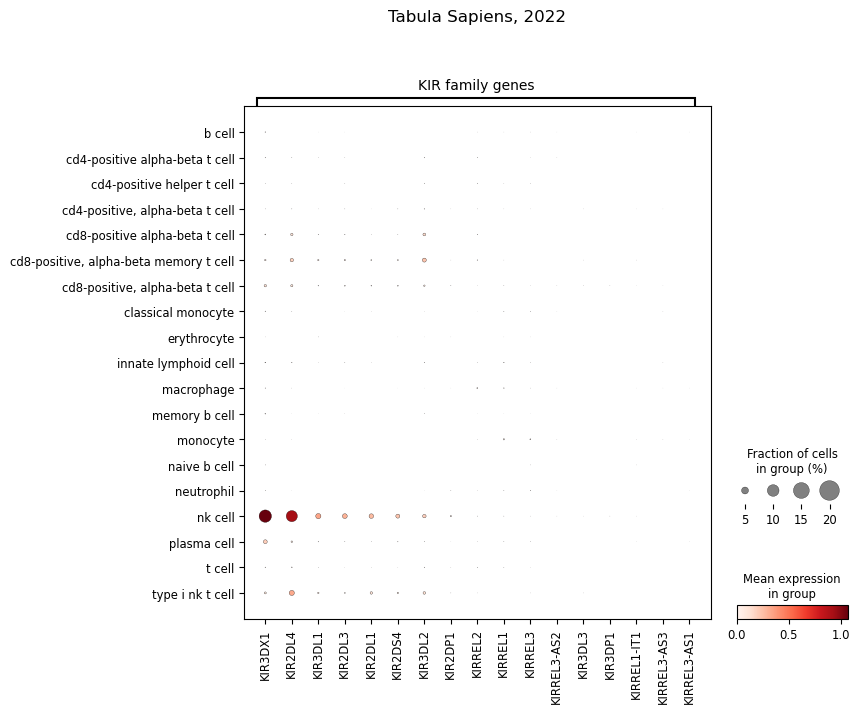

In [8]:
markers = {"KIR family genes": KIR_genes,
           # "IGSF8": "IGSF8"
          }
dp = sc.pl.dotplot(adata_immune,
                   markers, 
                   groupby='cell_ontology_class', 
                   # categories_order=["B16F10", "CT26", "MC38", "LL2", "EMT6", "Tcell", "NK", "Macro.", "Bcell", "pDC", "CAF"],
                   var_group_rotation=0,
                   use_raw=False,
                   title="Tabula Sapiens, 2022",
                   dendrogram=None,
                   return_fig=False)
# dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

In [60]:
sample_meta = pd.read_csv("/Users/caibin/Downloads/GSE119352_RAW/GSE119352_scRNA_lymphoid_meta_data.tsv.gz", sep='\t', index_col=0)
cell_meta = pd.read_csv("/Users/caibin/Downloads/GSE119352_RAW/GSE119352_scRNAseq_CD45_meta_data.tsv.gz", sep='\t', index_col=0)

In [88]:
GSE119352 = sc.read_mtx("/Users/caibin/Downloads/GSE119352_RAW/GSM3371684/matrix.mtx.gz").T
GSE119352.obs = pd.read_csv("/Users/caibin/Downloads/GSE119352_RAW/GSM3371684/barcodes.tsv.gz", header=None)
GSE119352.obs = GSE119352.obs.set_index(0).rename_axis('cells')
GSE119352.obs['GraphCluster'] = cell_meta['GraphCluster'].astype(str)
GSE119352.obs['Sample'] = cell_meta['Sample']
GSE119352.var = pd.read_csv("/Users/caibin/Downloads/GSE119352_RAW/GSM3371684/features.tsv.gz", header=None, sep='\t')
GSE119352.var = GSE119352.var.set_index(1).rename_axis('genes')
GSE119352.var_names_make_unique()

In [83]:
markers

{'Klra family genes': ['Klra2',
  'Klra5',
  'Klra17',
  'Klra4',
  'Klra7',
  'Klra1',
  'Klra8',
  'Klra6',
  'Klra9',
  'Klra10',
  'Klra3']}

In [87]:
GSE119352[~GSE119352.obs['GraphCluster'].isna()].obs['GraphCluster'].unique()

array([10.,  0.,  1.,  2.,  6., 15., 16.,  8.,  4.,  7.,  3.,  9.,  5.,
       11., 14., 13., 12., 18., 17.])

/Users/caibin/miniconda3/envs/general/lib/python3.11/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/caibin/miniconda3/envs/general/lib/python3.11/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/caibin/miniconda3/envs/general/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/caibin/miniconda3/envs/general/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will 

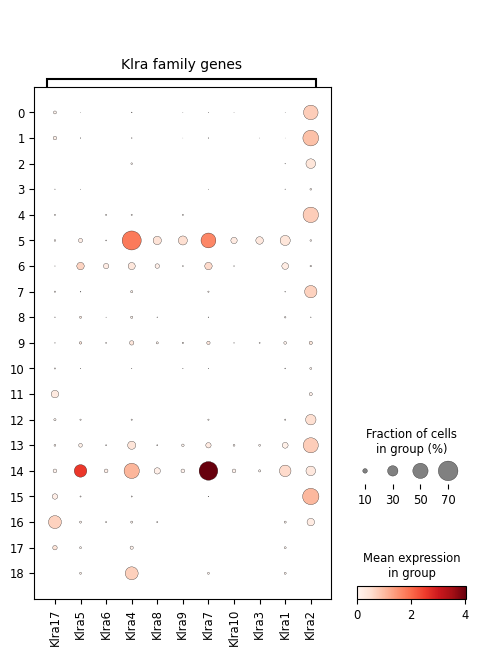

In [89]:
Klra_genes = GSE119352[GSE119352.obs['GraphCluster'].isin([8, 15])][:, GSE119352.var_names.str.startswith("Klra")].to_df().sum(axis=0).sort_values(ascending=False).index

markers = {"Klra family genes": list(Klra_genes),
           # "IGSF8": "IGSF8"
          }
dp = sc.pl.dotplot(GSE119352[~GSE119352.obs['GraphCluster'].isna()],
                   markers, 
                   groupby='GraphCluster', 
                   # categories_order=["B16F10", "CT26", "MC38", "LL2", "EMT6", "Tcell", "NK", "Macro.", "Bcell", "pDC", "CAF"],
                   var_group_rotation=0,
                   use_raw=False,
                   # title="Tabula Sapiens, 2022",
                   dendrogram=None,
                   return_fig=False)
# dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

View of AnnData object with n_obs × n_vars = 379 × 27998
    obs: 'GraphCluster', 'Sample'
    var: 0

<Axes: xlabel='tSNE_1', ylabel='tSNE_2'>

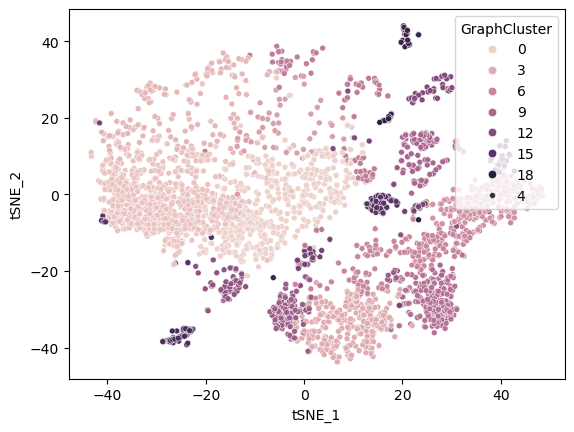

In [75]:
sns.scatterplot(data = cell_meta.query('Sample=="Control"'),
                x='tSNE_1',
                y='tSNE_2',
                hue='GraphCluster',
                size=4
               )

In [67]:
cell_meta.query('Sample=="Control"')

,tSNE_1,tSNE_2,GraphCluster,Sample
AAACATACAGCGTT-1,-1.898604,-29.047650,10,Control
AAACATACATTTCC-1,-10.603954,-6.274179,0,Control
AAACATACCCAACA-1,-22.066215,-5.995975,0,Control
AAACATACCCTTGC-1,-14.356492,-6.242678,1,Control
AAACATACTATGGC-1,-4.275077,-10.304621,0,Control
...,...,...,...,...
TTTCTACTCCCTAC-1,-17.959693,4.611707,1,Control
TTTCTACTGCTGTA-1,-40.351053,-7.154624,15,Control
TTTGCATGCTGTAG-1,-20.974491,8.711855,1,Control
TTTGCATGGCGGAA-1,-17.307821,-3.897942,1,Control


In [64]:
GSE119352.obs

,GraphCluster,Sample
cells,,
AAACATACAGCGTT-1,7.0,Control
AAACATACATTTCC-1,NaN,NaN
AAACATACCCAACA-1,NaN,NaN
AAACATACCCTTGC-1,NaN,NaN
AAACATACGGGTGA-1,NaN,NaN
...,...,...
TTTCTACTCCCTAC-1,NaN,NaN
TTTCTACTGCTGTA-1,NaN,NaN
TTTGCATGCTGTAG-1,NaN,NaN


In [57]:
GSE119352.obs

""
cells
AAACATACAGCGTT-1
AAACATACATTTCC-1
AAACATACCCAACA-1
AAACATACCCTTGC-1
AAACATACGGGTGA-1
...
TTTCTACTCCCTAC-1
TTTCTACTGCTGTA-1
TTTGCATGCTGTAG-1


In [55]:
GSE119352.var

,0
genes,
Xkr4,ENSMUSG00000051951
Gm1992,ENSMUSG00000089699
Gm37381,ENSMUSG00000102343
Rp1,ENSMUSG00000025900
Rp1,ENSMUSG00000109048
...,...
AC168977.1,ENSMUSG00000079808
PISD,ENSMUSG00000095041
DHRSX,ENSMUSG00000063897


In [17]:
cell_meta

,Unnamed: 0,tSNE_1,tSNE_2,GraphCluster,Sample
0,AAACATACAGCGTT-1,-1.898604,-29.047650,10,Control
1,AAACATACATTTCC-1,-10.603954,-6.274179,0,Control
2,AAACATACCCAACA-1,-22.066215,-5.995975,0,Control
3,AAACATACCCTTGC-1,-14.356492,-6.242678,1,Control
4,AAACATACTATGGC-1,-4.275077,-10.304621,0,Control
...,...,...,...,...,...
14488,TTTGCATGAAAACG-4,-19.377578,-1.504773,1,aPD1-aCTLA4
14489,TTTGCATGAAGATG-4,-3.281072,-28.079536,10,aPD1-aCTLA4
14490,TTTGCATGGAATGA-4,-5.261110,-30.920995,10,aPD1-aCTLA4
14491,TTTGCATGGTTCAG-4,-5.687810,37.877963,7,aPD1-aCTLA4


In [16]:
sample_meta

,Unnamed: 0,tSNE_1,tSNE_2,GraphCluster,Sample
0,AAACATACAGCGTT-1,-25.145830,-16.893633,7,Control
1,AAAGATCTAGAGGC-1,-23.048985,-22.754952,7,Control
2,AAAGATCTCTGGAT-1,-22.520046,-22.565856,7,Control
3,AAATCATGAAGTGA-1,-22.358282,-16.168614,7,Control
4,AAATCCCTGTCTGA-1,-24.614094,-19.171152,7,Control
...,...,...,...,...,...
4984,TAGCTACTAGGTTC-4,34.353412,10.786849,9,aPD1-aCTLA4
4985,TAGTAATGAACGGG-4,30.271906,-3.410261,10,aPD1-aCTLA4
4986,TCCTATGAAGTGCT-4,32.003375,0.305951,10,aPD1-aCTLA4
4987,TCGGTAGAATCTCT-4,34.339322,10.979701,9,aPD1-aCTLA4
